# To fix
- remove spanning deletions
- left align after normalising
- why some variants have same ref and alt?
- are pacbio variants restricted to core genome?

# Plan
- Create an annotation file with VARIANT_TYPE, MULTIALLELIC and CDS using code from 20160722_mendelian_error_duplicate_concordance
- Function to create, for a given sample and GQ threshold, a list of variants (maybe using bcftools)
- Create confusion matrix from GATK and Thomas versions
- Function to create, for a sample, TP, FPhom, FPhet, FN, broken down by coding/variant_type/multi-allelic
- Function to create sum of these across 5 samples
- Function to turn this into a table
- 3 (FPhom, FPhet, FPall) GQ ROC (FDR vs sensitivity) for coding/variant_type/multi-allelic (12 lines) across all samples
- GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
- 12 GQ ROCs with line for each sample
- VQSLOD ROCs for coding/variant_type/multi-allelic (12 lines) across all samples
- 12 VQSLOD ROCs with line for each sample
- Does VQSLOD threshold 0 look sane?
- Create table for given GQ threshold
- Create table for no GQ or VQSLOD threshold
- Create table for GQ=99 and VQSLOD>=6


- Create VCF with genotypes filtered by GQ (i.e. missing if GQ < threshold)
- Calculate summary of full data set
- Calculate crosses variables
- Calculate FDR/sensitivity

In [184]:
%run _standard_imports.ipynb
%run _shared_setup.ipynb
%run _plotting_setup.ipynb

python 3.4.5 |Anaconda 2.2.0 (64-bit)| (default, Jul  2 2016, 17:47:47) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy 1.11.1
scipy 0.18.0
pandas 0.19.0
numexpr 2.6.1
pysam 0.9.1.4
pysamstats 0.24.3
petl 1.1.0
petlx 1.0.3
vcf 0.6.8
vcfnp 2.3.0.dev0
h5py 2.4.0
tables 3.1.1


In [2]:
release5_final_files_dir = '/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0'
# chrom_vcf_fn = "%s/SNP_INDEL_Pf3D7_14_v3.combined.filtered.vcf.gz" % (release5_final_files_dir)
wg_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.vcf.gz" % (release5_final_files_dir)
crosses_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.crosses.vcf.gz" % (release5_final_files_dir)
sites_only_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.sites.vcf.gz" % (release5_final_files_dir)
pacbio_vcf_fn = "/nfs/team112_internal/rp7/data/pf3k/pacbio_3/vcf/pf3k_pacbio_3.vcf.gz" # See 20161012_pf3k_pacbio_3_setup.ipynb

output_dir = "/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary"
!mkdir -p {output_dir}/vcf

fdr_vcf_fn = "%s/vcf/SNP_INDEL_WG.combined.filtered.fdr.vcf.gz" % output_dir
pacbio_fdr_vcf_fn = "%s/vcf/pf3k_pacbio_3.fdr.vcf.gz" % output_dir
release5_crosses_metadata_txt_fn = '../../meta/pf3k_release_5_crosses_metadata.txt'
release5_mixtures_metadata_txt_fn = '../../meta/pf3k_release_5_mixtures_metadata.txt'
gff_fn = "%s/Pfalciparum.noseq.gff3.gz" % output_dir
cds_gff_fn = "%s/Pfalciparum.noseq.gff3.cds.gz" % output_dir
core_bed_fn = '/nfs/users/nfs_r/rp7/temp_github_src/pf-crosses/meta/regions-20130115.Conserved.bed'

summary_table_fn = "%s/callset_summary.xlsx" % output_dir
# simplifed_counts_table_fn = "%s/simplified_variant_counts.xlsx" % output_dir

GENOME_FN = "/lustre/scratch109/malaria/pf3k_methods/resources/Pfalciparum.genome.fasta"

BCFTOOLS = '/nfs/team112_internal/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/bcftools/bcftools'
GATK = '/software/jre1.7.0_25/bin/java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar'

In [3]:
wg_vcf_fn

'/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_WG.combined.filtered.vcf.gz'

In [4]:
pacbio_vcf_reader = vcf.Reader(filename=pacbio_vcf_fn)
pacbio_samples = np.array(pacbio_vcf_reader.samples)
pacbio_samples

array(['Pf7G8', 'PfGB4', 'PfGN01', 'PfKE01', 'PfKH02'], 
      dtype='<U6')

In [5]:
fdr_samples = collections.OrderedDict()
fdr_samples['Pf7G8'] = '7G8' # This is 76bp crosses parent
fdr_samples['PfGB4'] = 'GB4' # This is 76bp crosses parent
fdr_samples['PfGN01'] = 'ERS740940' # This is 100bp version created from 250bp MiSeq data
fdr_samples['PfKE01'] = 'ERS740937' # This is 100bp version created from 250bp MiSeq data
# fdr_samples['PfKH02'] = 'PH0197-C' # This is 76bp originally sequenced sample. There is also 100bp version created from 250bp MiSeq data (ERS740936)
fdr_samples['PfKH02'] = 'ERS740936' # This is 100bp version created from 250bp MiSeq data, There is also 76bp originally sequenced sample (PH0197-C)

In [6]:
fdr_samples_text = ','.join(list(fdr_samples.values()))
fdr_samples_text

'7G8,GB4,ERS740940,ERS740937,ERS740936'

In [7]:
!wget ftp://ftp.sanger.ac.uk/pub/project/pathogens/gff3/2016-06/Pfalciparum.noseq.gff3.gz \
    -O {gff_fn}

--2016-10-21 16:26:26--  ftp://ftp.sanger.ac.uk/pub/project/pathogens/gff3/2016-06/Pfalciparum.noseq.gff3.gz
           => `/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/Pfalciparum.noseq.gff3.gz'
Resolving ftp.sanger.ac.uk (ftp.sanger.ac.uk)... 193.62.203.17
Connecting to ftp.sanger.ac.uk (ftp.sanger.ac.uk)|193.62.203.17|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/project/pathogens/gff3/2016-06 ... done.
==> SIZE Pfalciparum.noseq.gff3.gz ... 4852221
==> PASV ... done.    ==> RETR Pfalciparum.noseq.gff3.gz ... done.
Length: 4852221 (4.6M) (unauthoritative)

100%[======================================>] 4,852,221   --.-K/s   in 0.1s    

2016-10-21 16:26:27 (38.9 MB/s) - `/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/Pfalciparum.noseq.gff3.gz' saved [4852221]



In [8]:
!zgrep CDS {gff_fn} | sort -k1,1 -k4n,5n | cut -f 1,4,5 | sed 's/$/\t1/' | bgzip -c > {cds_gff_fn} && tabix -s1 -b2 -e3 {cds_gff_fn}

In [7]:
annotations_header_fn = "%s/vcf/annotations.hdr" % (output_dir)
fo=open(annotations_header_fn, 'w')
print('##INFO=<ID=CDS,Number=0,Type=Flag,Description="Is position coding">', file=fo)
print('##INFO=<ID=VARIANT_TYPE,Number=1,Type=String,Description="SNP or indel (IND)">', file=fo)
print('##INFO=<ID=MULTIALLELIC,Number=1,Type=String,Description="Is position biallelic (BI), biallelic plus spanning deletion (SD) or truly multiallelic (MU)">', file=fo)
fo.close()

In [8]:
def create_multiallelics_file(input_vcf_fn=sites_only_vcf_fn, multiallelics_fn=None):
    if multiallelics_fn is None:
        multiallelics_fn = "%s/vcf/SNP_INDEL_WG.sites.multiallelics.txt" % (output_dir)
    fo = open(multiallelics_fn, 'w')
    input_vcf_reader = vcf.Reader(filename=input_vcf_fn)
#     for record in input_vcf_reader.fetch('Pf3D7_01_v3', 29000, 29100):
    for record in input_vcf_reader:
        if len(record.ALT) == 1:
            multiallelic = 'BI'
        elif len(record.ALT) == 2 and (record.ALT[0] == '*' or record.ALT[1] == '*'):
            multiallelic = 'SD'
        else:
            multiallelic = 'MU'
#         print(multiallelic, record.ALT)
        print("%s\t%s\t%s\t%s\t%s" % (
                record.CHROM,
                record.POS,
                record.REF,
                ",".join([str(x) for x in record.ALT]),
                multiallelic), file=fo)
    fo.close()
    
    !bgzip {multiallelics_fn} && tabix -s1 -b2 -e2 {multiallelics_fn}.gz

In [85]:
temp = create_multiallelics_file()
temp

In [9]:
def create_annotation_file(input_vcf_fn=sites_only_vcf_fn, annotation_fn=None, BCFTOOLS=BCFTOOLS, rewrite=False):
    if annotation_fn is None:
        annotation_fn = "%s/vcf/SNP_INDEL_WG.sites.annotation.txt.gz" % (output_dir)
                                               
    intermediate_fns = collections.OrderedDict()
    for intermediate_file in ['snp', 'indel', 'multiallelics']:
        intermediate_fns[intermediate_file] = annotation_fn.replace('annotation', intermediate_file)

    if rewrite or not os.path.exists(intermediate_fns['snp']):
        !{BCFTOOLS} query -f'%CHROM\t%POS\t%REF\t%ALT\tSNP\n' --include 'TYPE="snp"' {input_vcf_fn} | \
        bgzip -c > {intermediate_fns['snp']} && tabix -s1 -b2 -e2 -f {intermediate_fns['snp']}

    if rewrite or not os.path.exists(intermediate_fns['indel']):
        !{BCFTOOLS} query -f'%CHROM\t%POS\t%REF\t%ALT\tINDEL\n' --include 'TYPE!="snp"' {input_vcf_fn} | \
        bgzip -c > {intermediate_fns['indel']} && tabix -s1 -b2 -e2 -f {intermediate_fns['indel']}

    if rewrite or not os.path.exists(intermediate_fns['multiallelics']):
        create_multiallelics_file(input_vcf_fn, "%s/vcf/pf3k_pacbio_3.multiallelics.txt" % (output_dir))
        
    if rewrite or not os.path.exists(annotation_fn):
        !{BCFTOOLS} annotate -a {cds_gff_fn} -c CHROM,FROM,TO,CDS -h {annotations_header_fn} {input_vcf_fn} | \
        {BCFTOOLS} annotate -a {intermediate_fns['snp']} -c CHROM,POS,REF,ALT,INFO/VARIANT_TYPE | \
        {BCFTOOLS} annotate -a {intermediate_fns['indel']} -c CHROM,POS,REF,ALT,INFO/VARIANT_TYPE | \
        {BCFTOOLS} annotate -a {intermediate_fns['multiallelics']} -c CHROM,POS,REF,ALT,INFO/MULTIALLELIC | \
        {BCFTOOLS} query -f'%CHROM\t%POS\t%REF\t%ALT\t%CDS\t%VARIANT_TYPE\t%MULTIALLELIC\n' | \
        bgzip -c > {annotation_fn}
        !tabix -s1 -b2 -e2 {annotation_fn}
      

In [87]:
create_annotation_file()

In [13]:
create_annotation_file(pacbio_vcf_fn, "%s/vcf/pf3k_pacbio_3.annotation.txt.gz" % (output_dir))

In [12]:
!zgrep SNP /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
!zgrep INDEL /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep SNP SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep INDEL SNP_INDEL_WG.sites.annotation.txt.gz | wc -l

2561890+1650575

2561890
1650575


4212465

In [90]:
# Here sanity checking that:
# a) Multi-allelic annotations are added 1-1
# b) Every position has a multi-allelic annotation

!zgrep MU /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
!zgrep BI /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
!zgrep SD /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l

!zgrep MU /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.multiallelics.txt.gz | wc -l
!zgrep BI /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.multiallelics.txt.gz | wc -l
!zgrep SD /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.multiallelics.txt.gz | wc -l

# zgrep MU SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep BI SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep SD SNP_INDEL_WG.sites.annotation.txt.gz | wc -l

# 1180582+2118683+913200
1267853+2116676+827936

1267853
2116676
827936
1267853
2116676
827936


4212465

In [91]:
# This command is slow (~1.5 hours)

annotation_fn = "%s/vcf/SNP_INDEL_WG.sites.annotation.txt.gz" % (output_dir)

# !{BCFTOOLS} view --regions Pf3D7_01_v3:29000-30000 --min-ac 1 -s {fdr_samples_text} {wg_vcf_fn} | \
!{BCFTOOLS} view --regions-file {core_bed_fn} --min-ac 1 -s {fdr_samples_text} {wg_vcf_fn} | \
{BCFTOOLS} norm -m -any --fasta-ref {GENOME_FN} | \
{BCFTOOLS} view --include 'ALT!="*"' | \
{BCFTOOLS} annotate -h {annotations_header_fn} \
-a {annotation_fn} -c CHROM,POS,REF,ALT,CDS,VARIANT_TYPE,MULTIALLELIC \
--include 'INFO/AC>0' \
--remove ^INFO/AC,INFO/AN,INFO/AF,INFO/VQSLOD,^FORMAT/GT,FORMAT/AD,FORMAT/GQ -Oz -o {fdr_vcf_fn}

!{BCFTOOLS} index --tbi {fdr_vcf_fn}

Lines   total/split/realigned/skipped:	283133/253218/339064/0


In [90]:
pacbio_annotation_fn = "%s/vcf/pf3k_pacbio_3.annotation.txt.gz" % (output_dir)

!{BCFTOOLS} view --regions-file {core_bed_fn} --min-ac 1 {pacbio_vcf_fn} | \
{BCFTOOLS} norm -m -any --fasta-ref {GENOME_FN} | \
{BCFTOOLS} view --include 'ALT!="*"' | \
{BCFTOOLS} annotate -h {annotations_header_fn} \
-a {pacbio_annotation_fn} -c CHROM,POS,REF,ALT,CDS,VARIANT_TYPE,MULTIALLELIC \
--include 'INFO/AC>0' \
--remove ^INFO/AC,INFO/AN,^FORMAT/GT,FORMAT/AD,FORMAT/GQ -Oz -o {pacbio_fdr_vcf_fn}

!{BCFTOOLS} index --tbi {pacbio_fdr_vcf_fn}

Lines   total/split/realigned/skipped:	138566/50292/48401/0


In [93]:
def create_variants_npy(vcf_fn):
    output_dir = '%s.vcfnp_cache' % vcf_fn
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    vcfnp.variants(
        vcf_fn,
        fields=['CHROM', 'POS', 'REF', 'ALT', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC',
                'AC', 'AN', 'FILTER'],
        dtypes={
            'REF':                      'a200',
            'ALT':                      'a200',
            'VARIANT_TYPE':             'a3',
            'CDS':                      bool,
            'MULTIALLELIC':             'a2',
        },
        arities={
            'ALT':   1,
            'AC':    1,
        },
        flatten_filter=True,
        progress=100000,
        verbose=True,
        cache=True,
        cachedir=output_dir
    )

def create_calldata_npy(vcf_fn, max_alleles=2):
    output_dir = '%s.vcfnp_cache' % vcf_fn
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    vcfnp.calldata_2d(
        vcf_fn,
        fields=['GT', 'AD', 'GQ'],
        dtypes={
            'AD': 'u2',
        },
        arities={
            'AD': max_alleles,
        },
        progress=100000,
        verbose=True,
        cache=True,
        cachedir=output_dir
    )


In [94]:
create_variants_npy(fdr_vcf_fn)
create_calldata_npy(fdr_vcf_fn)


[vcfnp] 2016-10-21 11:11:23.898359 :: caching is enabled
[vcfnp] 2016-10-21 11:11:23.900831 :: no cache file found
[vcfnp] 2016-10-21 11:11:23.901873 :: building array
[vcfnp] 2016-10-21 11:11:26.745341 :: 100000 rows in 2.80s; batch in 2.80s (35757 rows/s)
[vcfnp] 2016-10-21 11:11:28.575096 :: 169464 rows in 4.63s (36629 rows/s)
[vcfnp] 2016-10-21 11:11:28.576519 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.combined.filtered.fdr.vcf.gz.vcfnp_cache/variants.npy
[vcfnp] 2016-10-21 11:11:28.723833 :: caching is enabled
[vcfnp] 2016-10-21 11:11:28.733069 :: no cache file found
[vcfnp] 2016-10-21 11:11:28.734260 :: building array
[vcfnp] 2016-10-21 11:11:33.669547 :: 100000 rows in 4.88s; batch in 4.88s (20491 rows/s)
[vcfnp] 2016-10-21 11:11:36.939550 :: 169464 rows in 8.15s (20792 rows/s)
[vcfnp] 2016-10-21 11:11:36.941084 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_s

In [95]:
create_variants_npy(pacbio_fdr_vcf_fn)
create_calldata_npy(pacbio_fdr_vcf_fn)


[vcfnp] 2016-10-21 11:11:41.646747 :: caching is enabled
[vcfnp] 2016-10-21 11:11:41.649909 :: no cache file found
[vcfnp] 2016-10-21 11:11:41.651157 :: building array
[vcfnp] 2016-10-21 11:11:44.028893 :: 100000 rows in 2.30s; batch in 2.30s (43455 rows/s)
[vcfnp] 2016-10-21 11:11:46.094792 :: 200000 rows in 4.37s; batch in 2.07s (48405 rows/s)
[vcfnp] 2016-10-21 11:11:46.327683 :: 210538 rows in 4.60s (45768 rows/s)
[vcfnp] 2016-10-21 11:11:46.329374 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/pf3k_pacbio_3.fdr.vcf.gz.vcfnp_cache/variants.npy
[vcfnp] 2016-10-21 11:11:46.494958 :: caching is enabled
[vcfnp] 2016-10-21 11:11:46.497579 :: no cache file found
[vcfnp] 2016-10-21 11:11:46.499799 :: building array
[vcfnp] 2016-10-21 11:11:51.008049 :: 100000 rows in 4.49s; batch in 4.49s (22295 rows/s)
[vcfnp] 2016-10-21 11:11:55.522822 :: 200000 rows in 9.00s; batch in 4.51s (22149 rows/s)
[vcfnp] 2016-10-21 11:11:56.010554 :: 21

In [10]:
gatk_variants = np.load("%s.vcfnp_cache/variants.npy" % fdr_vcf_fn)
gatk_calldata = np.load("%s.vcfnp_cache/calldata_2d.npy" % fdr_vcf_fn)

pacbio_variants = np.load("%s.vcfnp_cache/variants.npy" % pacbio_fdr_vcf_fn)
pacbio_calldata = np.load("%s.vcfnp_cache/calldata_2d.npy" % pacbio_fdr_vcf_fn)


In [14]:
gatk_variants

array([ (b'Pf3D7_01_v3', 93157, b'T', b'A', False, b'SNP', b'BI', 2, 10, False, False, False, False, True, False, False, False, False, False, False, False),
       (b'Pf3D7_01_v3', 93241, b'C', b'T', False, b'IND', b'MU', 1, 10, False, False, False, True, False, False, False, False, False, False, False, False),
       (b'Pf3D7_01_v3', 93247, b'A', b'G', False, b'IND', b'MU', 1, 10, False, False, False, True, False, False, False, False, False, False, False, False),
       ...,
       (b'Pf3D7_14_v3', 3254696, b'A', b'G', True, b'SNP', b'BI', 2, 10, False, False, False, False, True, False, False, False, False, False, False, False),
       (b'Pf3D7_14_v3', 3255220, b'C', b'A', True, b'IND', b'MU', 2, 8, False, False, False, False, True, False, False, False, False, False, False, False),
       (b'Pf3D7_14_v3', 3255607, b'A', b'G', True, b'SNP', b'BI', 6, 8, False, False, False, False, True, False, False, False, False, False, False, False)], 
      dtype=[('CHROM', 'S12'), ('POS', '<i4'), (

In [11]:
gatk_vcf_reader = vcf.Reader(filename=fdr_vcf_fn)
gatk_samples = np.array(gatk_vcf_reader.samples)
gatk_samples

array(['7G8', 'GB4', 'ERS740940', 'ERS740937', 'ERS740936'], 
      dtype='<U9')

In [12]:
gatk_samples == fdr_samples['Pf7G8']

array([ True, False, False, False, False], dtype=bool)

In [17]:
np.unique(gatk_calldata['GT'][:, gatk_samples == fdr_samples['Pf7G8']], return_counts=True)

(array([b'./.', b'0/0', b'0/1', b'1/0', b'1/1'], 
       dtype='|S3'), array([  8407, 108567,  11369,   1036,  40085]))

In [101]:
temp = np.in1d(gatk_calldata['GT'][:, gatk_samples == fdr_samples['Pf7G8']], [b'0/1', b'1/0'])
print(np.unique(temp, return_counts=True))
temp = np.in1d(gatk_calldata['GT'][:, gatk_samples == fdr_samples['Pf7G8']], [b'1/1'])
print(np.unique(temp, return_counts=True))
temp = gatk_calldata['GT'][:, gatk_samples == fdr_samples['Pf7G8']] == [b'1/1']
print(np.unique(temp, return_counts=True))


(array([False,  True], dtype=bool), array([157059,  12405]))
(array([False,  True], dtype=bool), array([129379,  40085]))
(array([False,  True], dtype=bool), array([129379,  40085]))


In [111]:
def classify_call(rec):
    if rec['CDS_GATK'] is None and rec['CDS_PACBIO'] is None:
        return('!!')
    elif rec['CDS_GATK'] is None:
        return('FN')
    elif rec['CDS_PACBIO'] is None:
        return('FP')
    else:
        return('TP')

def determine_fdr(sample='Pf7G8', GQ_threshold=30):
    ix_gatk_het_calls = np.in1d(gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][:,0], [b'0/1', b'1/0'])
    ix_gatk_hom_calls = (gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][:,0] == b'1/1')
    ix_pass = gatk_variants['FILTER_PASS']
    ix_gq_good = (gatk_calldata['GQ'][:, gatk_samples == fdr_samples[sample]][:,0] >= GQ_threshold)
    ix_good_calls = np.logical_and(ix_pass, ix_gq_good)
    ix_good_het_calls = np.logical_and(ix_good_calls, ix_gatk_het_calls)
    ix_good_hom_calls = np.logical_and(ix_good_calls, ix_gatk_hom_calls)
#     print(np.unique(ix_good_het_calls, return_counts=True))
#     print(np.unique(ix_good_hom_calls, return_counts=True))
    
    ix_pacbio_calls = (pacbio_calldata['GT'][:, pacbio_samples == sample][:,0] == b'1/1')
    
    columns_of_interest = ['CHROM', 'POS', 'REF', 'ALT', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC']
    tbl_gatk_calls = etl.fromarray(gatk_variants[ix_good_hom_calls]).cut(columns_of_interest).rename('CDS', 'CDS_GATK')
    tbl_pacbio_calls = etl.fromarray(pacbio_variants[ix_pacbio_calls]).cut(columns_of_interest).rename('CDS', 'CDS_PACBIO')
    tbl_calls = (tbl_gatk_calls
        .outerjoin(tbl_pacbio_calls, key=['CHROM', 'POS', 'REF', 'ALT'])
        .addfield('status', classify_call)
    )
    tbl_counts = tbl_calls.valuecounts('status')
    num_FP = tbl_counts.selecteq('status', 'FP').values('count')[0]
    num_TP = tbl_counts.selecteq('status', 'TP').values('count')[0]
    print(num_FP, num_TP, num_FP/(num_FP+num_TP))
    return(tbl_calls)

In [35]:
import pandas as pd

def classify_call_pd(rec):
    if np.isnan(rec['CDS_x']) and np.isnan(rec['CDS_y']):
        return('!!')
    elif np.isnan(rec['CDS_x']):
        return('FN')
    elif np.isnan(rec['CDS_y']):
        return('FP')
    else:
        return('TP')
    
def cds_pd(rec):
    if np.isnan(rec['CDS_x']) and np.isnan(rec['CDS_y']):
        return(np.nan)
    elif np.isnan(rec['CDS_x']):
        return(rec['CDS_y'])
    else:
        return(rec['CDS_x'])
    
def variant_type_pd(rec):
#     print(type(rec['VARIANT_TYPE_x']), rec['VARIANT_TYPE_x'])
#     print(type(rec['VARIANT_TYPE_y']), rec['VARIANT_TYPE_y'])
    if isinstance(rec['VARIANT_TYPE_x'], float) and isinstance(rec['VARIANT_TYPE_y'], float):
#         print('here2')
        return(b'!!!')
    elif isinstance(rec['VARIANT_TYPE_x'], float):
#         print('here3')
        return(rec['VARIANT_TYPE_y'])
    else:
#         print('here')
        return(rec['VARIANT_TYPE_x'])
    
def determine_fdr_pd(sample='Pf7G8', GQ_threshold=30):
    ix_gatk_het_calls = np.in1d(gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][:,0], [b'0/1', b'1/0'])
    ix_gatk_hom_calls = (gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][:,0] == b'1/1')
    ix_pass = gatk_variants['FILTER_PASS']
    ix_gq_good = (gatk_calldata['GQ'][:, gatk_samples == fdr_samples[sample]][:,0] >= GQ_threshold)
    ix_good_calls = np.logical_and(ix_pass, ix_gq_good)
    ix_good_het_calls = np.logical_and(ix_good_calls, ix_gatk_het_calls)
    ix_good_hom_calls = np.logical_and(ix_good_calls, ix_gatk_hom_calls)
#     print(np.unique(ix_good_het_calls, return_counts=True))
#     print(np.unique(ix_good_hom_calls, return_counts=True))
    
    ix_pacbio_calls = (pacbio_calldata['GT'][:, pacbio_samples == sample][:,0] == b'1/1')
    
    columns_of_interest = ['CHROM', 'POS', 'REF', 'ALT', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC']
    pd_gatk_calls = pd.DataFrame(gatk_variants[ix_good_hom_calls]).loc[:, columns_of_interest]
#     .rename(columns={'CDS': 'CDS_GATK'})
    pd_pacbio_calls = pd.DataFrame(pacbio_variants[ix_pacbio_calls]).loc[:, columns_of_interest]
#     .rename(columns={'CDS': 'CDS_PACBIO'})
    df_calls = pd.merge(pd_gatk_calls, pd_pacbio_calls, how='outer', on=['CHROM', 'POS', 'REF', 'ALT']).sort(['CHROM', 'POS', 'REF', 'ALT'])
    df_calls['status'] = df_calls.apply(classify_call_pd, 1)
    df_counts = df_calls['status'].value_counts()
    num_FPhom = df_counts['FP']
    num_FPhet = np.count_nonzero(ix_good_het_calls)
    num_TP = df_counts['TP']
    num_FN = df_counts['FN']
    print(sample, GQ_threshold, num_FP, num_TP, num_FN, num_FP/(num_FP+num_TP), num_TP/(num_TP+num_FN))
#     gb = 
#     return(tbl_calls)

In [151]:
import pandas as pd

def classify_call_pd(rec):
#     print(rec)
#     print(rec['CDS_x'], rec['CDS_y'])
    if not rec['CDS_x'] in [True, False] and not rec['CDS_y'] in [True, False]:
        return('!!!NR')
    elif not rec['CDS_x'] in [True, False]:
        return('FN')
    elif not rec['CDS_y'] in [True, False] and rec['GT'] == b'1/1':
        return('FPhom')
    elif not rec['CDS_y'] in [True, False] and rec['GT'] in [b'0/1', b'1/0']:
        return('FPhet')
    elif not rec['CDS_y'] in [True, False] and rec['GT'] == b'0/0':
        return('!TPHR')
    elif not rec['CDS_y'] in [True, False] and not rec['GT'] in [b'0/0', b'0/1', b'1/0', b'1/1']:
        return('!!!FP')
    elif not rec['GT'] in [b'0/0', b'0/1', b'1/0', b'1/1']:
        return('!!!FN')        
    elif rec['GT'] in [b'0/1', b'1/0']:
        return('TPhet')
    elif rec['GT'] == b'0/0':
        return('!FPHR')
    elif rec['GT'] == b'0/0':
        return('TPhom')
    else:
        return('!!!NM')

def set_status(df_calls):
    df_calls.assign(status='!!!NM')
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] == b'MIS'),
                 'status'] = '!!!NR'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS'),
                 'status'] = 'FN'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (df_calls['GT'] == b'1/1'),
                 'status'] = 'FPhom'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (np.in1d(df_calls['GT'], [b'0/1', b'1/0'])),
                 'status'] = 'FPhet'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (df_calls['GT'] == b'0/0'),
                 'status'] = '!TPHR'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (np.logical_not(np.in1d(df_calls['GT'], [b'0/0', b'0/1', b'1/0', b'1/1']))),
                 'status'] = '!!!FP'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] != b'MIS') & (df_calls['VARIANT_TYPE_x'] != b'MIS') & (np.logical_not(np.in1d(df_calls['GT'], [b'0/0', b'0/1', b'1/0', b'1/1']))),
                 'status'] = '!!!FN'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'0/1', b'1/0'])),
                 'status'] = 'TPhet'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'1/1'])),
                 'status'] = 'TPhom'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'0/0'])),
                 'status'] = '!FPHR'
    return(df_calls)

def set_cds(df_calls):
    df_calls.assign(CDS=b'MIS')
    df_calls.loc[(df_calls['CDS_x'] == b'MIS'), 'CDS'] = df_calls.loc[(df_calls['CDS_x'] == b'MIS'), 'CDS_y']
    df_calls.loc[(df_calls['CDS_x'] != b'MIS'), 'CDS'] = df_calls.loc[(df_calls['CDS_x'] != b'MIS'), 'CDS_x']
    return(df_calls)

def set_variant_type(df_calls):
    df_calls.assign(VARIANT_TYPE=b'MIS')
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS'), 'VARIANT_TYPE'] = df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS'), 'VARIANT_TYPE_y']
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS'), 'VARIANT_TYPE'] = df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS'), 'VARIANT_TYPE_x']
    return(df_calls)

def cds_pd(rec):
    if np.isnan(rec['CDS_x']) and np.isnan(rec['CDS_y']):
        return(np.nan)
    elif np.isnan(rec['CDS_x']):
        return(rec['CDS_y'])
    else:
        return(rec['CDS_x'])

def determine_fdr_pd(sample='Pf7G8', GQ_threshold=30):
    columns_of_interest = ['CHROM', 'POS', 'REF', 'ALT', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC']
    ix_good_calls = np.logical_and(
        gatk_variants['FILTER_PASS'],
        gatk_calldata['GQ'][:, gatk_samples == fdr_samples[sample]][:,0] >= GQ_threshold
    )
    ix_pacbio_calls = (pacbio_calldata['GT'][:, pacbio_samples == sample][:,0] == b'1/1')
    gatk_GT = gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][:,0]
    df_gatk_calls = pd.DataFrame(gatk_variants[ix_good_calls]).loc[:, columns_of_interest]
    df_gatk_calls['GT'] = gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][ix_good_calls][:,0]
    df_pacbio_calls = pd.DataFrame(pacbio_variants[ix_pacbio_calls]).loc[:, columns_of_interest]
    df_calls = pd.merge(
        df_gatk_calls, df_pacbio_calls, how='outer', on=['CHROM', 'POS', 'REF', 'ALT']
    )
    df_calls['VARIANT_TYPE_x'].fillna(b'MIS', inplace=True)
    df_calls['VARIANT_TYPE_y'].fillna(b'MIS', inplace=True)
    df_calls['CDS_x'].fillna(b'MIS', inplace=True)
    df_calls['CDS_y'].fillna(b'MIS', inplace=True)
    df_calls['MULTIALLELIC_x'].fillna(b'MIS', inplace=True)
    df_calls = set_status(df_calls)
    df_calls = set_cds(df_calls)
    df_calls = set_variant_type(df_calls)
    
    gb = df_calls.groupby(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC_x', 'status']).size()
    return(gb, df_calls)
    


In [128]:
df_calls.shape

(127960, 14)

In [131]:
df_calls.groupby('status').size()

status
!FPHR      314
!TPHR    65269
FN       28680
FPhet     1237
FPhom      642
TPhet      903
TPhom    30915
dtype: int64

In [160]:
gb, df_calls = determine_fdr_pd()
df_gb = pd.DataFrame(gb)
df_gb.head(70)
df_gb.index

MultiIndex(levels=[[b'IND', b'SNP'], [False, True], [b'BI', b'MIS', b'MU', b'SD'], ['!FPHR', '!TPHR', 'FN', 'FPhet', 'FPhom', 'TPhet', 'TPhom']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3], [0, 1, 3, 4, 5, 6, 2, 0, 1, 3, 4, 5, 6, 0, 1, 3, 4, 5, 6, 0, 1, 3, 4, 5, 6, 2, 0, 1, 3, 4, 5, 6, 0, 1, 3, 4, 5, 6, 1, 3, 4, 5, 6, 2, 1, 3, 4, 5, 6, 0, 1, 3, 4, 5, 

In [165]:
df_gb.groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()

0
VARIANT_TYPE CDS   status       
b'IND'       False !FPHR     126
                   !TPHR   37783
                   FN      21287
                   FPhet     890
                   FPhom     315
                   TPhet     769
                   TPhom   16650
             True  !FPHR     165
                   !TPHR    9947
                   FN       2378
                   FPhet     154
                   FPhom     195
                   TPhet      77
                   TPhom    3982
b'SNP'       False !FPHR       5
                   !TPHR    7310
                   FN       2794
                   FPhet     132
                   FPhom      70
                   TPhet      33
                   TPhom    4335
             True  !FPHR      18
                   !TPHR   10229
                   FN       2221
                   FPhet      61
                   FPhom      62
                   TPhet      24
                   TPhom    5948

In [171]:
gb.groupby(level=['status']).sum()

status
!FPHR      314
!TPHR    65269
FN       28680
FPhet     1237
FPhom      642
TPhet      903
TPhom    30915
dtype: int64

In [172]:
for sample in pacbio_samples:
    print()
    for GQ_threshold in np.arange(0, 100, 10):
        gb, _ = determine_fdr_pd(sample, GQ_threshold)
        status_sum = gb.groupby(level=['status']).sum()
        FP = status_sum['FPhom'] + status_sum['FPhet']
        TP = status_sum['TPhom']
        FN = status_sum['FN']
        FDR = FP/(TP+FP)
        sensitivity = TP/(TP+FN)
        print(sample, GQ_threshold, FDR, sensitivity)



Pf7G8 0 0.11393139459 0.652113578138
Pf7G8 10 0.079671264428 0.599447655091
Pf7G8 20 0.0673900144104 0.557458451561
Pf7G8 30 0.0572970665366 0.518751573119
Pf7G8 40 0.0490852445976 0.479157620495
Pf7G8 50 0.0441487644801 0.443867099675
Pf7G8 60 0.0418252427184 0.409973081652
Pf7G8 70 0.0400490051117 0.376995055911
Pf7G8 80 0.038396873722 0.350596421471
Pf7G8 90 0.0377082010453 0.326121503062

PfGB4 0 0.131043736171 0.650037859445
PfGB4 10 0.0862152204294 0.613466164003
PfGB4 20 0.071887000188 0.584044476739
PfGB4 30 0.0618785158248 0.554482712297
PfGB4 40 0.0547767236691 0.522968138812
PfGB4 50 0.0488641097119 0.494551997601
PfGB4 60 0.0454313945197 0.467241723175
PfGB4 70 0.0422652133112 0.440217661795
PfGB4 80 0.0402362778566 0.414649101003
PfGB4 90 0.0390156307391 0.389928462608

PfGN01 0 0.0791384029513 0.622275834339
PfGN01 10 0.0433542934243 0.594607424286
PfGN01 20 0.0319398778769 0.552372694309
PfGN01 30 0.025283126606 0.483402032661
PfGN01 40 0.0246589716684 0.379661922267
Pf

In [175]:
FDR = np.zeros(100, dtype=float)
sensitivity = np.zeros(100, dtype=float)
for GQ_threshold in np.arange(0, 100):
    TP = 0
    FP = 0
    FN = 0
    for sample in pacbio_samples:
        gb, _ = determine_fdr_pd(sample, GQ_threshold)
        status_sum = gb.groupby(level=['status']).sum()
        FP = FP + status_sum['FPhom'] + status_sum['FPhet']
        TP = TP + status_sum['TPhom']
        FN = FN + status_sum['FN']
    FDR[GQ_threshold] = FP/(TP+FP)
    sensitivity[GQ_threshold] = TP/(TP+FN)
    print(GQ_threshold, FDR[GQ_threshold], sensitivity[GQ_threshold])


0 0.0893526125534 0.662965241464
1 0.0707261905903 0.651745323286
2 0.0692448292448 0.649582060492
3 0.067694075501 0.647513085933
4 0.0652421071043 0.644211837506
5 0.0639543670624 0.642323776388
6 0.0627208567038 0.640232017786
7 0.0600628340529 0.635468605455
8 0.0590813099216 0.633402078369
9 0.0578813015331 0.631366402668
10 0.055539060023 0.625253205043
11 0.0545681369355 0.623192217546
12 0.0535264004384 0.620673478419
13 0.0517262645055 0.613367860491
14 0.0509050007223 0.61117719374
15 0.0498628602834 0.608497285451
16 0.0484982132237 0.599880549472
17 0.047756522107 0.597259347205
18 0.0468965883728 0.594524625594
19 0.0457381693918 0.584668135363
20 0.0449365540853 0.581961594628
21 0.0441068794055 0.579061653857
22 0.043083129489 0.568154750089
23 0.0424796121402 0.564950676442
24 0.0418686993978 0.561806370564
25 0.0412241016627 0.54968445399
26 0.0406643192352 0.546243967855
27 0.0400322313181 0.542884314386
28 0.0394806808745 0.530649361795
29 0.038921507291 0.5271994693

KeyboardInterrupt: 

In [176]:
GQ_dict = collections.OrderedDict()
for GQ_threshold in np.arange(0, 100):
    print(GQ_threshold, end=" ")
    GQ_dict[GQ_threshold] = collections.OrderedDict()
    for sample in pacbio_samples:
        GQ_dict[GQ_threshold][sample], _ = determine_fdr_pd(sample, GQ_threshold)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [178]:
GQ_dict[30]['Pf7G8']

VARIANT_TYPE  CDS    MULTIALLELIC_x  status
b'IND'        False  b'BI'           !FPHR         4
                                     !TPHR       978
                                     FPhet        11
                                     FPhom         8
                                     TPhet         8
                                     TPhom       525
                     b'MIS'          FN        21287
                     b'MU'           !FPHR       111
                                     !TPHR     34767
                                     FPhet       799
                                     FPhom       281
                                     TPhet       709
                                     TPhom     15398
                     b'SD'           !FPHR        11
                                     !TPHR      2038
                                     FPhet        80
                                     FPhom        26
                                     TPhet        52
  

In [177]:
FDR = np.zeros(100, dtype=float)
sensitivity = np.zeros(100, dtype=float)
for GQ_threshold in np.arange(0, 100):
    TP = 0
    FP = 0
    FN = 0
    for sample in pacbio_samples:
        status_sum = GQ_dict[GQ_threshold][sample].groupby(level=['status']).sum()
        FP = FP + status_sum['FPhom'] + status_sum['FPhet']
        TP = TP + status_sum['TPhom']
        FN = FN + status_sum['FN']
    FDR[GQ_threshold] = FP/(TP+FP)
    sensitivity[GQ_threshold] = TP/(TP+FN)
    print(GQ_threshold, FDR[GQ_threshold], sensitivity[GQ_threshold])


0 0.0893526125534 0.662965241464
1 0.0707261905903 0.651745323286
2 0.0692448292448 0.649582060492
3 0.067694075501 0.647513085933
4 0.0652421071043 0.644211837506
5 0.0639543670624 0.642323776388
6 0.0627208567038 0.640232017786
7 0.0600628340529 0.635468605455
8 0.0590813099216 0.633402078369
9 0.0578813015331 0.631366402668
10 0.055539060023 0.625253205043
11 0.0545681369355 0.623192217546
12 0.0535264004384 0.620673478419
13 0.0517262645055 0.613367860491
14 0.0509050007223 0.61117719374
15 0.0498628602834 0.608497285451
16 0.0484982132237 0.599880549472
17 0.047756522107 0.597259347205
18 0.0468965883728 0.594524625594
19 0.0457381693918 0.584668135363
20 0.0449365540853 0.581961594628
21 0.0441068794055 0.579061653857
22 0.043083129489 0.568154750089
23 0.0424796121402 0.564950676442
24 0.0418686993978 0.561806370564
25 0.0412241016627 0.54968445399
26 0.0406643192352 0.546243967855
27 0.0400322313181 0.542884314386
28 0.0394806808745 0.530649361795
29 0.038921507291 0.5271994693

In [230]:
GQ_dict[30]['Pf7G8'].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()[b'IND'][True]['FPhom']

195

In [237]:
'FPhom' in GQ_dict[30]['Pf7G8'].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()[b'IND'][True].keys()

True

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


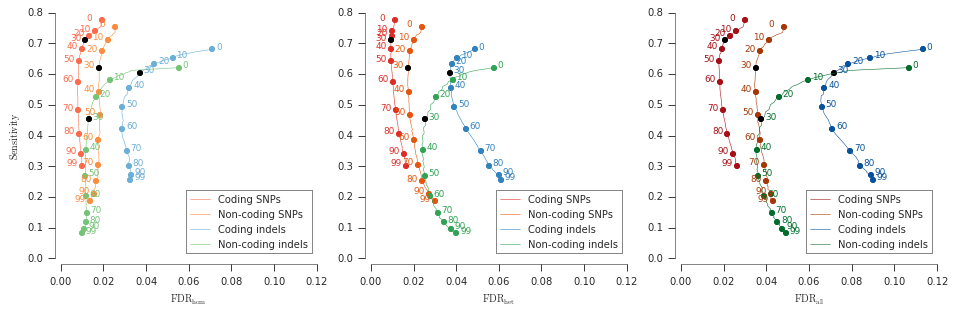

In [288]:
# MAYBE REDO THIS AS THREE SEPARATE PLOTS (HOM, HET, ALL)?

#  GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

FDR = collections.OrderedDict()
sensitivity = collections.OrderedDict()
for variant_type in [b'SNP', b'IND']:
    FDR[variant_type] = collections.OrderedDict()
    sensitivity[variant_type] = collections.OrderedDict()
    for coding in [True, False]:
        FDR[variant_type][coding] = collections.OrderedDict()
        FDR[variant_type][coding]['FPhom'] = np.zeros(100, dtype=float)
        FDR[variant_type][coding]['FPhet'] = np.zeros(100, dtype=float)
        FDR[variant_type][coding]['FPall'] = np.zeros(100, dtype=float)
        sensitivity[variant_type][coding] = np.zeros(100, dtype=float)
        for GQ_threshold in np.arange(0, 100):
            TP = 0
            FPhom = 0
            FPhet = 0
            FPall = 0
            FN = 0
            for sample in pacbio_samples:
                status_sum = GQ_dict[GQ_threshold][sample].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()
#                 print(status_sum[variant_type][coding].keys())
                if 'FPhom' in status_sum[variant_type][coding].keys():
                    FPhom = FPhom + status_sum[variant_type][coding]['FPhom']
                if 'FPhet' in status_sum[variant_type][coding].keys():
                    FPhet = FPhet + status_sum[variant_type][coding]['FPhet']
                FPall = FPhom + FPhet
#                 FPall = FPall + status_sum[variant_type][coding]['FPhom'] + status_sum[variant_type][coding]['FPhet']
                if 'TPhom' in status_sum[variant_type][coding].keys():
                    TP = TP + status_sum[variant_type][coding]['TPhom']
                if 'FN' in status_sum[variant_type][coding].keys():
                    FN = FN + status_sum[variant_type][coding]['FN']
#             print(variant_type, coding, GQ_threshold, FPhom, FPhet, FPall, TP, FN)
            FDR[variant_type][coding]['FPhom'][GQ_threshold] = FPhom/(TP+FPhom)
            FDR[variant_type][coding]['FPhet'][GQ_threshold] = FPhet/(TP+FPhet)
            FDR[variant_type][coding]['FPall'][GQ_threshold] = FPall/(TP+FPall)
            sensitivity[variant_type][coding][GQ_threshold] = TP/(TP+FN)
        colour = df_colours['colour'][variant_type][coding][b'hom']
        if variant_type == b'SNP':
            text_offset = -0.007
        else:
            text_offset = 0.002
        if coding == True and variant_type == b'SNP':
            label = "Coding SNPs" 
        if coding == False and variant_type == b'SNP':
            label = "Non-coding SNPs" 
        if coding == True and variant_type == b'IND':
            label = "Coding indels" 
        if coding == False and variant_type == b'IND':
            label = "Non-coding indels" 
        ax1.plot(FDR[variant_type][coding]['FPhom'], sensitivity[variant_type][coding], color=colour, label=label)
        for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
            if GQ == 30:
                ax1.plot(FDR[variant_type][coding]['FPhom'][GQ], sensitivity[variant_type][coding][GQ], 'o', color="black")
            else:
                ax1.plot(FDR[variant_type][coding]['FPhom'][GQ], sensitivity[variant_type][coding][GQ], 'o', color=colour)
            ax1.text(FDR[variant_type][coding]['FPhom'][GQ]+text_offset, sensitivity[variant_type][coding][GQ], GQ, fontsize=8, color=colour)
        colour = df_colours['colour'][variant_type][coding][b'het']
        ax2.plot(FDR[variant_type][coding]['FPhet'], sensitivity[variant_type][coding], color=colour, label=label)
        for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
            if GQ == 30:
                ax2.plot(FDR[variant_type][coding]['FPhet'][GQ], sensitivity[variant_type][coding][GQ], 'o', color="black")
            else:
                ax2.plot(FDR[variant_type][coding]['FPhet'][GQ], sensitivity[variant_type][coding][GQ], 'o', color=colour)
            ax2.text(FDR[variant_type][coding]['FPhet'][GQ]+text_offset, sensitivity[variant_type][coding][GQ], GQ, fontsize=8, color=colour)
        colour = df_colours['colour'][variant_type][coding][b'all']
        ax3.plot(FDR[variant_type][coding]['FPall'], sensitivity[variant_type][coding], color=colour, label=label)
        for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
            if GQ == 30:
                ax3.plot(FDR[variant_type][coding]['FPall'][GQ], sensitivity[variant_type][coding][GQ], 'o', color="black")
            else:
                ax3.plot(FDR[variant_type][coding]['FPall'][GQ], sensitivity[variant_type][coding][GQ], 'o', color=colour)
            ax3.text(FDR[variant_type][coding]['FPall'][GQ]+text_offset, sensitivity[variant_type][coding][GQ], GQ, fontsize=8, color=colour)
        sns.despine(ax=ax1, offset=5)
        sns.despine(ax=ax2, offset=5)
        sns.despine(ax=ax3, offset=5)
        ax1.set_xlim(0, 0.12)
        ax2.set_xlim(0, 0.12)
        ax3.set_xlim(0, 0.12)
        ax1.set_xlabel(r'$\mathrm{FDR_{hom}}$')
        ax2.set_xlabel(r'$\mathrm{FDR_{het}}$')
        ax3.set_xlabel(r'$\mathrm{FDR_{all}}$')
        ax1.set_ylabel(r'$\mathrm{Sensitivity}$')
        ax1.legend(loc='lower right')
        ax2.legend(loc='lower right')
        ax3.legend(loc='lower right')

fig.tight_layout()


In [298]:
sample_colours = { # ColorBrewer 5-class Set 1
    'Pf7G8': '#e41a1c',
    'PfGB4': '#377eb8',
    'PfGN01': '#4daf4a',
    'PfKE01': '#984ea3',
    'PfKH02': '#ff7f00',
}
sample_colours['PfKE01']

'#984ea3'

In [297]:
pacbio_samples

array(['Pf7G8', 'PfGB4', 'PfGN01', 'PfKE01', 'PfKH02'], 
      dtype='<U6')

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


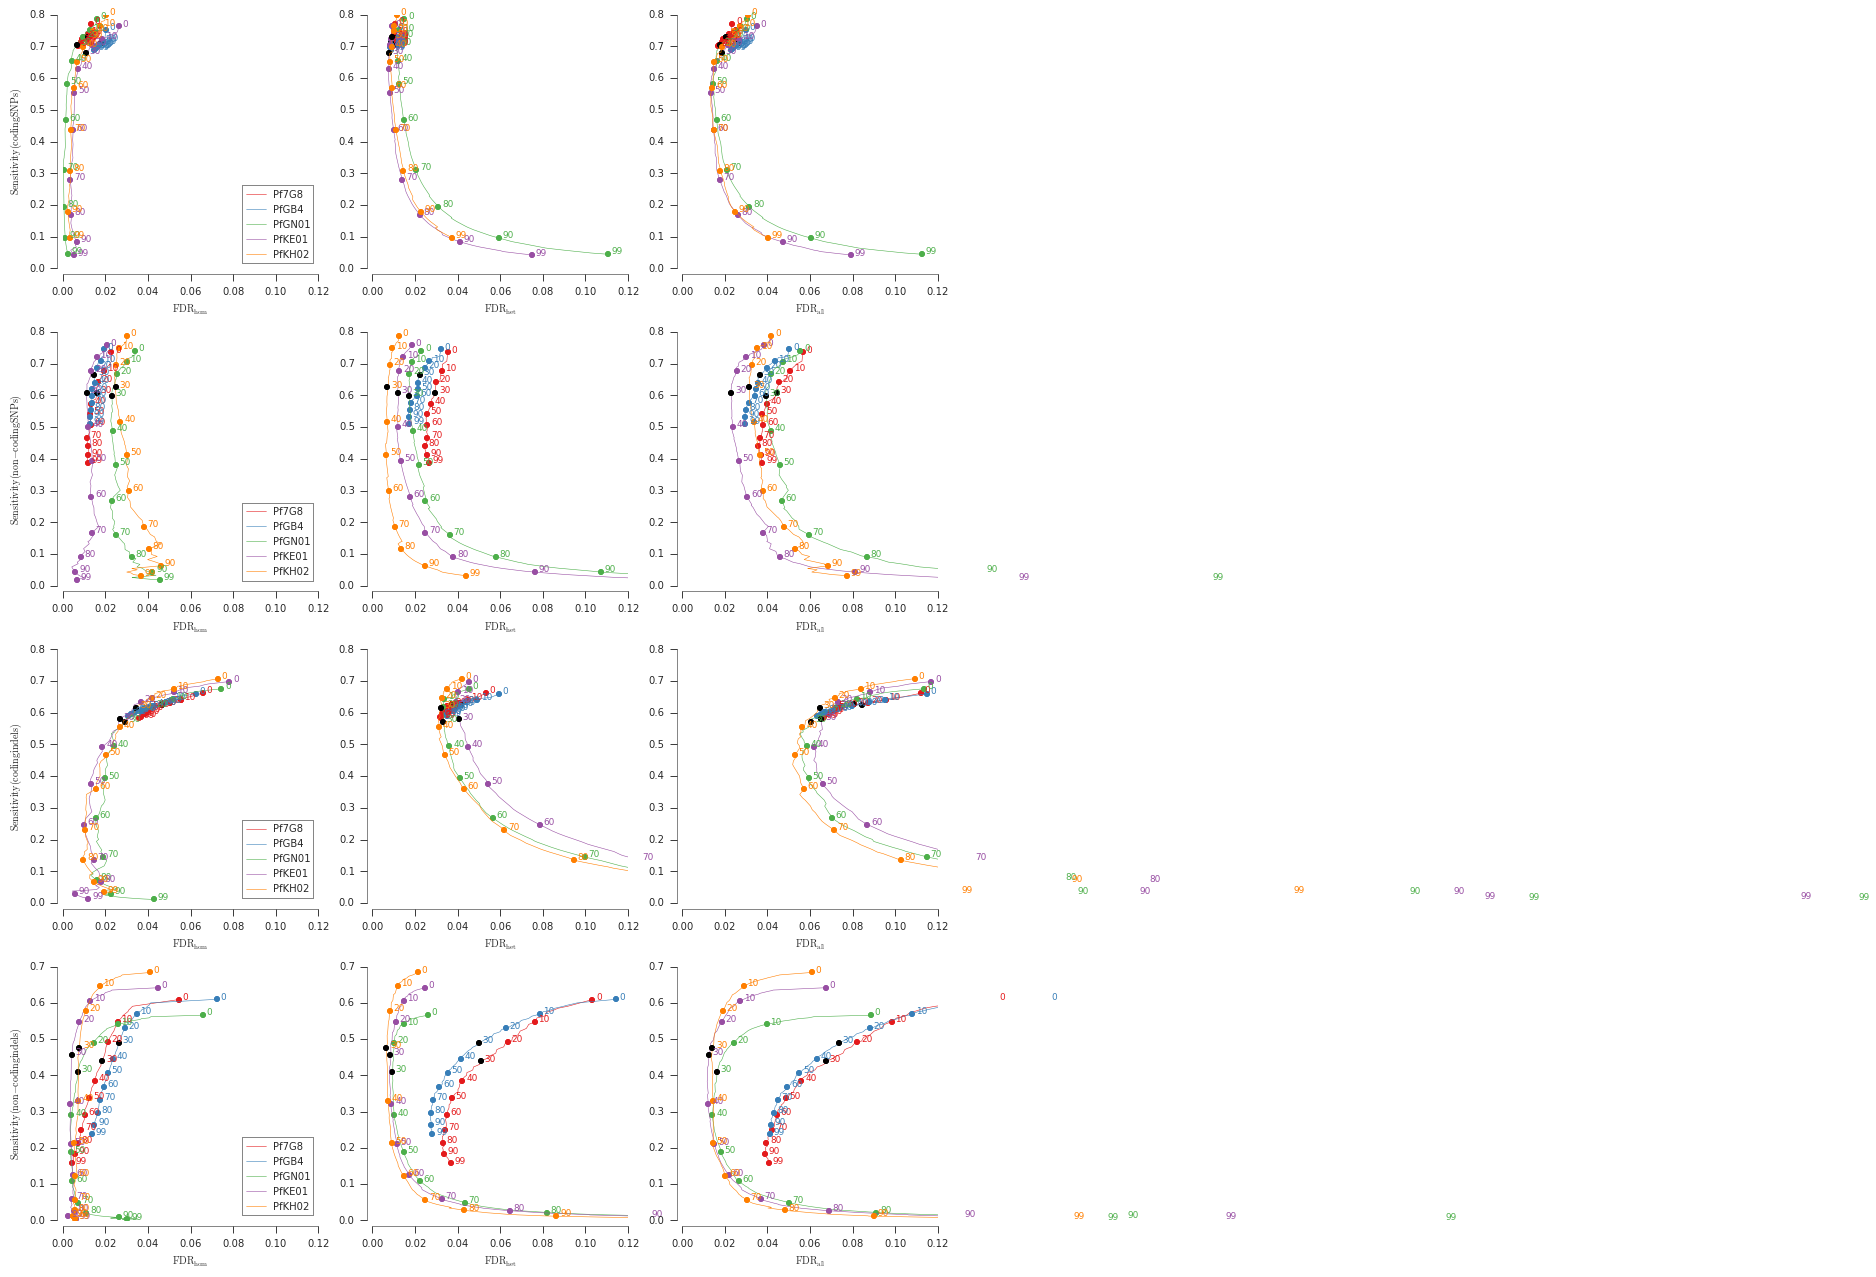

In [303]:
#  GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
fig = plt.figure(figsize=(12, 16))
gs = mpl.gridspec.GridSpec(4, 3)
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

FDR = collections.OrderedDict()
sensitivity = collections.OrderedDict()
for i, variant_type in enumerate([b'SNP', b'IND']):
    FDR[variant_type] = collections.OrderedDict()
    sensitivity[variant_type] = collections.OrderedDict()
    for j, coding in enumerate([True, False]):
        FDR[variant_type][coding] = collections.OrderedDict()
        sensitivity[variant_type][coding] = collections.OrderedDict()
        row_num = (i*2) + j
        ax1 = fig.add_subplot(gs[row_num, 0])
        ax2 = fig.add_subplot(gs[row_num, 1])
        ax3 = fig.add_subplot(gs[row_num, 2])
        for sample in pacbio_samples:
            FDR[variant_type][coding][sample] = collections.OrderedDict()
            FDR[variant_type][coding][sample]['FPhom'] = np.zeros(100, dtype=float)
            FDR[variant_type][coding][sample]['FPhet'] = np.zeros(100, dtype=float)
            FDR[variant_type][coding][sample]['FPall'] = np.zeros(100, dtype=float)
            sensitivity[variant_type][coding][sample] = np.zeros(100, dtype=float)
            for GQ_threshold in np.arange(0, 100):
                status_sum = GQ_dict[GQ_threshold][sample].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()
#             TP = 0
#             FPhom = 0
#             FPhet = 0
#             FPall = 0
#             FN = 0
#                 print(status_sum[variant_type][coding].keys())
                if 'FPhom' in status_sum[variant_type][coding].keys():
                    FPhom = status_sum[variant_type][coding]['FPhom']
                if 'FPhet' in status_sum[variant_type][coding].keys():
                    FPhet = status_sum[variant_type][coding]['FPhet']
                FPall = FPhom + FPhet
#                 FPall = FPall + status_sum[variant_type][coding]['FPhom'] + status_sum[variant_type][coding]['FPhet']
                if 'TPhom' in status_sum[variant_type][coding].keys():
                    TP = status_sum[variant_type][coding]['TPhom']
                if 'FN' in status_sum[variant_type][coding].keys():
                    FN = status_sum[variant_type][coding]['FN']
#             print(variant_type, coding, GQ_threshold, FPhom, FPhet, FPall, TP, FN)
                FDR[variant_type][coding][sample]['FPhom'][GQ_threshold] = FPhom/(TP+FPhom)
                FDR[variant_type][coding][sample]['FPhet'][GQ_threshold] = FPhet/(TP+FPhet)
                FDR[variant_type][coding][sample]['FPall'][GQ_threshold] = FPall/(TP+FPall)
                sensitivity[variant_type][coding][sample][GQ_threshold] = TP/(TP+FN)
            colour = sample_colours[sample]
#             colour = df_colours['colour'][variant_type][coding][b'hom']
#             if variant_type == b'SNP':
#                 text_offset = -0.007
#             else:
#                 text_offset = 0.002
            if coding == True and variant_type == b'SNP':
                label = "Sensitivity (coding SNPs)" 
            if coding == False and variant_type == b'SNP':
                label = "Sensitivity (non-coding SNPs)" 
            if coding == True and variant_type == b'IND':
                label = "Sensitivity (coding indels)" 
            if coding == False and variant_type == b'IND':
                label = "Sensitivity (non-coding indels)" 
            ax1.plot(FDR[variant_type][coding][sample]['FPhom'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax1.plot(FDR[variant_type][coding][sample]['FPhom'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax1.plot(FDR[variant_type][coding][sample]['FPhom'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax1.text(FDR[variant_type][coding][sample]['FPhom'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
#             colour = df_colours['colour'][variant_type][coding][b'het']
            ax2.plot(FDR[variant_type][coding][sample]['FPhet'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax2.plot(FDR[variant_type][coding][sample]['FPhet'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax2.plot(FDR[variant_type][coding][sample]['FPhet'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax2.text(FDR[variant_type][coding][sample]['FPhet'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
#             colour = df_colours['colour'][variant_type][coding][[sample]b'all']
            ax3.plot(FDR[variant_type][coding][sample]['FPall'], sensitivity[variant_type][coding][sample], color=colour, label=sample)
            for GQ in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                if GQ == 30:
                    ax3.plot(FDR[variant_type][coding][sample]['FPall'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color="black")
                else:
                    ax3.plot(FDR[variant_type][coding][sample]['FPall'][GQ], sensitivity[variant_type][coding][sample][GQ], 'o', color=colour)
                ax3.text(FDR[variant_type][coding][sample]['FPall'][GQ]+text_offset, sensitivity[variant_type][coding][sample][GQ], GQ, fontsize=8, color=colour)
            sns.despine(ax=ax1, offset=5)
            sns.despine(ax=ax2, offset=5)
            sns.despine(ax=ax3, offset=5)
            ax1.set_xlim(0, 0.12)
            ax2.set_xlim(0, 0.12)
            ax3.set_xlim(0, 0.12)
            ax1.set_xlabel(r'$\mathrm{FDR_{hom}}$')
            ax2.set_xlabel(r'$\mathrm{FDR_{het}}$')
            ax3.set_xlabel(r'$\mathrm{FDR_{all}}$')
            ax1.set_ylabel(r'$\mathrm{%s}$' % label)
            ax1.legend(loc='lower right')

fig.tight_layout()


In [293]:
GQ_dict.groupby(level=['sample', 'VARIANT_TYPE', 'CDS', 'status']).sum()

AttributeError: 'OrderedDict' object has no attribute 'groupby'

VARIANT_TYPE  CDS    MULTIALLELIC_x  status
b'IND'        False  b'BI'           !!!FN        17
                                     !!!FP        14
                                     !FPHR         3
                                     !TPHR      1413
                                     FPhet        10
                                     FPhom        14
                                     TPhet        10
                                     TPhom       643
                     b'MIS'          FN        14196
                     b'MU'           !!!FN       257
                                     !!!FP      2713
                                     !FPHR       508
                                     !TPHR     58178
                                     FPhet      2712
                                     FPhom      1675
                                     TPhet      2131
                                     TPhom     20588
                     b'SD'           !!!FN        18
  

In [198]:
variant_type = b'SNP'
coding = True

colour = df_colours['colour'][
    (df_colours['VARIANT_TYPE']==variant_type) & (df_colours['CDS_GATK']==coding) & (df_colours['FDR']==b'het')
][0]

KeyError: 0

In [193]:
(df_colours['VARIANT_TYPE']==variant_type) & (df_colours['CDS_GATK']==coding) & (df_colours['FDR']==b'hom')

0     False
1      True
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
dtype: bool

In [ ]:
for GQ in np.arange(0, 100):
    

In [15]:
temp = df_calls.apply(classify_call_pd, 1, raw=True)

In [77]:
df_calls.assign(bothMiss='!!!NR' * df_calls['VARIANT_TYPE_x'] == b'MIS')

TypeError: can't multiply sequence by non-int of type 'str'

In [38]:
def classify_rec(rec):
    '!!!NR' if rec['VARIANT_TYPE_x'] == b'MIS' and rec['VARIANT_TYPE_y'] == b'MIS' else \
    'FN' if rec['VARIANT_TYPE_x'] == b'MIS' else \
    '!!!FN'

In [63]:
temp = map(lambda x: 'A' * x, np.array((df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] == b'MIS')))

In [68]:
['A' * x for x in [True, False, True]]

['A', '', 'A']

In [93]:
def set_status(df_calls)
    df_calls.append(status='!!!NM')
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] == b'MIS'),
                 'status'] = '!!!NR'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] == b'MIS'),
                 'status'] = 'FN'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (df_calls['GT'] == b'1/1'),
                 'status'] = 'FPhom'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (np.in1d(df_calls['GT'], [b'0/1', b'1/0'])),
                 'status'] = 'FPhet'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (df_calls['GT'] == b'0/0'),
                 'status'] = '!TPHR'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (np.logical_not(np.in1d(df_calls['GT'], [b'0/0', b'0/1', b'1/0', b'1/1']))),
                 'status'] = '!!!FP'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.logical_not(np.in1d(df_calls['GT'], [b'0/0', b'0/1', b'1/0', b'1/1']))),
                 'status'] = '!!!FN'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'0/1', b'1/0'])),
                 'status'] = 'TPhet'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'1/1'])),
                 'status'] = 'TPhom'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'0/0'])),
                 'status'] = '!FPHR'
    return(df_calls)

In [94]:
df_calls['new_column_3'].value_counts()

FN       66506
FPhom      642
Name: new_column_3, dtype: int64

In [92]:
df_calls['new_column_2'].value_counts()

FN       66506
         60812
FPhom      642
Name: new_column_2, dtype: int64

In [90]:
df_calls['new_column'].value_counts()

FN       66506
         60812
FPhom      642
Name: new_column, dtype: int64

In [75]:
temp=np.array(['!!!NR' * int(x) for x in ((df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] == b'SNP'))])
# 'FN' * ((df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS'))

In [76]:
np.unique(temp, return_counts=True)

(array(['', '!!!NR'], 
       dtype='<U5'), array([122945,   5015]))

In [46]:
'!!!NR' * ((df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] == b'IND')).value_counts(dropna=False)

False    104295
True      23665
dtype: int64

In [48]:
False * 'yesy'

''

In [42]:
df_calls['VARIANT_TYPE_x'] == b'MIS'

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
127930     True
127931     True
127932     True
127933     True
127934     True
127935     True
127936     True
127937     True
127938     True
127939     True
127940     True
127941     True
127942     True
127943     True
127944     True
127945     True
127946     True
127947     True
127948     True
127949     True
127950     True
127951     True
127952     True
127953     True
127954     True
127955     True
127956     True
127957     True
127958     True
127959     True
Name: VARIANT_TYPE_x, dt

In [39]:
classify_rec(df_calls)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [30]:
df_calls['VARIANT_TYPE_x'].fillna(b'MIS', inplace=True)
df_calls['VARIANT_TYPE_y'].fillna(b'MIS', inplace=True)


In [36]:
df_calls['VARIANT_TYPE_x'].value_counts(dropna=False)

b'IND'    71053
b'MIS'    28680
b'SNP'    28227
Name: VARIANT_TYPE_x, dtype: int64

In [37]:
df_calls['VARIANT_TYPE_y'].value_counts(dropna=False)

b'MIS'    67148
b'IND'    43567
b'SNP'    17245
Name: VARIANT_TYPE_y, dtype: int64

In [20]:
temp2 = classify_rec(df_calls)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [21]:
df_calls

,CHROM,POS,REF,ALT,CDS_x,VARIANT_TYPE_x,MULTIALLELIC_x,GT,CDS_y,VARIANT_TYPE_y,MULTIALLELIC_y
0,b'Pf3D7_01_v3',93157,b'T',b'A',False,b'SNP',b'BI',b'1/1',False,b'SNP',b'BI'
1,b'Pf3D7_01_v3',93318,b'G',b'A',False,b'SNP',b'MU',b'0/1',NaN,NaN,NaN
2,b'Pf3D7_01_v3',93378,b'G',b'T',False,b'SNP',b'BI',b'0/0',NaN,NaN,NaN
3,b'Pf3D7_01_v3',94422,b'C',b'T',False,b'SNP',b'BI',b'0/1',NaN,NaN,NaN
4,b'Pf3D7_01_v3',94427,b'C',b'CG',False,b'IND',b'MU',b'0/1',NaN,NaN,NaN
5,b'Pf3D7_01_v3',94457,b'A',b'C',False,b'SNP',b'MU',b'0/1',NaN,NaN,NaN
6,b'Pf3D7_01_v3',94459,b'C',b'A',False,b'SNP',b'BI',b'0/1',NaN,NaN,NaN
7,b'Pf3D7_01_v3',94487,b'A',b'T',False,b'SNP',b'BI',b'0/1',NaN,NaN,NaN
8,b'Pf3D7_01_v3',94505,b'T',b'TAAA',False,b'IND',b'MU',b'0/1',NaN,NaN,NaN
9,b'Pf3D7_01_v3',94519,b'T',b'A',False,b'SNP',b'MU',b'0/1',NaN,NaN,NaN


In [16]:
temp

0         !!!NM
1         FPhet
2         !TPHR
3         FPhet
4         FPhet
5         FPhet
6         FPhet
7         FPhet
8         FPhet
9         FPhet
10        FPhet
11        FPhet
12        FPhet
13        FPhet
14        FPhet
15        FPhet
16        FPhet
17        FPhet
18        FPhet
19        FPhet
20        FPhet
21        FPhet
22        !!!NM
23        !TPHR
24        !TPHR
25        !TPHR
26        !TPHR
27        !TPHR
28        !!!NM
29        !TPHR
          ...  
127930       FN
127931       FN
127932       FN
127933       FN
127934       FN
127935       FN
127936       FN
127937       FN
127938       FN
127939       FN
127940       FN
127941       FN
127942       FN
127943       FN
127944       FN
127945       FN
127946       FN
127947       FN
127948       FN
127949       FN
127950       FN
127951       FN
127952       FN
127953       FN
127954       FN
127955       FN
127956       FN
127957       FN
127958       FN
127959       FN
dtype: object

In [210]:
sample='Pf7G8'
GQ_threshold=30
ix_gatk_het_calls = np.in1d(gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][:,0], [b'0/1', b'1/0'])
ix_gatk_hom_calls = (gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][:,0] == b'1/1')
ix_pass = gatk_variants['FILTER_PASS']
ix_gq_good = (gatk_calldata['GQ'][:, gatk_samples == fdr_samples[sample]][:,0] >= GQ_threshold)
ix_good_calls = np.logical_and(ix_pass, ix_gq_good)
ix_good_het_calls = np.logical_and(ix_good_calls, ix_gatk_het_calls)
ix_good_hom_calls = np.logical_and(ix_good_calls, ix_gatk_hom_calls)
ix_pacbio_calls = (pacbio_calldata['GT'][:, pacbio_samples == sample][:,0] == b'1/1')
columns_of_interest = ['CHROM', 'POS', 'REF', 'ALT', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC']
pd_gatk_calls = pd.DataFrame(gatk_variants[ix_good_hom_calls]).loc[:, columns_of_interest]
# .rename(columns={'CDS': 'CDS_GATK'})
pd_pacbio_calls = pd.DataFrame(pacbio_variants[ix_pacbio_calls]).loc[:, columns_of_interest]
# .rename(columns={'CDS': 'CDS_PACBIO'})
df_calls = pd.merge(pd_gatk_calls, pd_pacbio_calls, how='outer', on=['CHROM', 'POS', 'REF', 'ALT']).sort(['CHROM', 'POS', 'REF', 'ALT'])
df_calls['status'] = df_calls.apply(classify_call_pd, 1)
df_calls['CDS'] = df_calls.apply(cds_pd, 1)
df_calls['VARIANT_TYPE'] = df_calls.apply(variant_type_pd, 1)
df_counts = df_calls['status'].value_counts()

df_counts

TP    30915
FN    29897
FP      642
dtype: int64

In [179]:
float('NaN')

nan

In [184]:
df_calls.head()

,CHROM,POS,REF,ALT,CDS_x,VARIANT_TYPE_x,MULTIALLELIC_x,CDS_y,VARIANT_TYPE_y,MULTIALLELIC_y,status,CDS
0,b'Pf3D7_01_v3',93157,b'T',b'A',False,b'SNP',b'BI',False,b'SNP',b'BI',TP,False
31557,b'Pf3D7_01_v3',93901,b'A',b'AATATATATATATATATATAT',NaN,NaN,NaN,False,b'IND',b'MU',FN,False
31558,b'Pf3D7_01_v3',94257,b'A',b'AATAT',NaN,NaN,NaN,False,b'IND',b'MU',FN,False
31559,b'Pf3D7_01_v3',94588,b'C',b'CATATAT',NaN,NaN,NaN,False,b'IND',b'BI',FN,False
1,b'Pf3D7_01_v3',94993,b'CATATATATAT',b'C',False,b'IND',b'MU',False,b'IND',b'BI',TP,False


In [192]:
df_calls[df_calls['VARIANT_TYPE_x'].isnull()]

,CHROM,POS,REF,ALT,CDS_x,VARIANT_TYPE_x,MULTIALLELIC_x,CDS_y,VARIANT_TYPE_y,MULTIALLELIC_y,status,CDS
31557,b'Pf3D7_01_v3',93901,b'A',b'AATATATATATATATATATAT',NaN,NaN,NaN,False,b'IND',b'MU',FN,False
31558,b'Pf3D7_01_v3',94257,b'A',b'AATAT',NaN,NaN,NaN,False,b'IND',b'MU',FN,False
31559,b'Pf3D7_01_v3',94588,b'C',b'CATATAT',NaN,NaN,NaN,False,b'IND',b'BI',FN,False
31560,b'Pf3D7_01_v3',96437,b'GTATATATATATATATATA',b'G',NaN,NaN,NaN,False,b'IND',b'MU',FN,False
31561,b'Pf3D7_01_v3',96836,b'TTATAAA',b'T',NaN,NaN,NaN,False,b'IND',b'BI',FN,False
31562,b'Pf3D7_01_v3',97825,b'AT',b'A',NaN,NaN,NaN,False,b'IND',b'BI',FN,False
31563,b'Pf3D7_01_v3',98418,b'G',b'GAA',NaN,NaN,NaN,False,b'IND',b'MU',FN,False
31564,b'Pf3D7_01_v3',98517,b'T',b'A',NaN,NaN,NaN,False,b'SNP',b'BI',FN,False
31565,b'Pf3D7_01_v3',98571,b'ATTTT',b'A',NaN,NaN,NaN,False,b'IND',b'MU',FN,False
31566,b'Pf3D7_01_v3',99187,b'A',b'AT',NaN,NaN,NaN,False,b'IND',b'MU',FN,False


In [157]:
for sample in pacbio_samples:
    print()
    for GQ_threshold in np.arange(0, 100, 10):
        determine_fdr_pd(sample, GQ_threshold)


Pf7G8 0 1738 36654 24158 0.045269847885 0.602742879695
Pf7G8 10 945 35163 25649 0.0261714855434 0.578224692495
Pf7G8 20 757 33006 27806 0.0224209933951 0.542754719463
Pf7G8 30 642 30915 29897 0.0203441391767 0.508370058541
Pf7G8 40 513 28691 32121 0.0175660868374 0.471798329277
Pf7G8 50 433 26652 34160 0.0159867085102 0.438268762744
Pf7G8 60 381 24673 36139 0.0152071525505 0.405725843584
Pf7G8 70 329 22723 38089 0.0142720805136 0.373659803986
Pf7G8 80 297 21162 39650 0.0138403467077 0.347990528185
Pf7G8 90 265 19701 41111 0.0132725633577 0.323965664671

PfGB4 0 2223 36915 23918 0.0567990188564 0.606825242878
PfGB4 10 1182 35962 24871 0.0318220977816 0.591159403613
PfGB4 20 991 34562 26271 0.027873878435 0.56814557888
PfGB4 30 874 33020 27813 0.0257862748569 0.542797494781
PfGB4 40 758 31285 29548 0.0236557126361 0.514276790558
PfGB4 50 655 29684 31149 0.0215893734138 0.487958838131
PfGB4 60 585 28113 32720 0.0203846957976 0.462134039091
PfGB4 70 527 26535 34298 0.0194738009016 0.43619

In [112]:
tbl_calls = determine_fdr()

(array([False,  True], dtype=bool), array([167324,   2140]))
(array([False,  True], dtype=bool), array([137907,  31557]))
642 30915 0.020344139176727827


In [104]:
def confusion_tr_style(row):
    style = 'background-color: %s' % ('#4f4' if row.status == 'TP' 
                                      else '#f44' if row.status == 'FP'
                                      else '#44f' if row.status == 'FN'
                                      else 'white')
    return style


In [105]:
tbl_calls.display(100, tr_style=confusion_tr_style)

CHROM,POS,REF,ALT,CDS_GATK,VARIANT_TYPE,MULTIALLELIC,CDS_PACBIO,VARIANT_TYPE,MULTIALLELIC,status
b'Pf3D7_01_v3',93157,b'T',b'A',False,b'SNP',b'BI',False,b'SNP',b'BI',TP
b'Pf3D7_01_v3',93901,b'A',b'AATATATATATATATATATAT',None,None,None,False,b'IND',b'MU',FN
b'Pf3D7_01_v3',94257,b'A',b'AATAT',None,None,None,False,b'IND',b'MU',FN
b'Pf3D7_01_v3',94588,b'C',b'CATATAT',None,None,None,False,b'IND',b'BI',FN
b'Pf3D7_01_v3',94993,b'CATATATATAT',b'C',False,b'IND',b'MU',False,b'IND',b'BI',TP
b'Pf3D7_01_v3',96437,b'GTATATATATATATATATA',b'G',None,None,None,False,b'IND',b'MU',FN
b'Pf3D7_01_v3',96836,b'TTATAAA',b'T',None,None,None,False,b'IND',b'BI',FN
b'Pf3D7_01_v3',97296,b'TTA',b'T',False,b'IND',b'BI',False,b'IND',b'BI',TP
b'Pf3D7_01_v3',97825,b'AT',b'A',None,None,None,False,b'IND',b'BI',FN
b'Pf3D7_01_v3',98126,b'A',b'AAAAT',False,b'IND',b'MU',False,b'IND',b'BI',TP


In [110]:
len(tbl_calls.selecteq('status', 'FP').data())

642

In [107]:
tbl_calls.valuecounts('status')

status,count,frequency
TP,30915,0.5030591987502848
FN,29897,0.4864939629641683
FP,642,0.010446838285546912


In [108]:
642/(642+30915)

0.020344139176727827

In [106]:
tbl_calls.valuecounts('VARIANT_TYPE', 'CDS_GATK', 'MULTIALLELIC', 'status').sort(('VARIANT_TYPE', 'CDS_GATK', 'MULTIALLELIC', 'status')).displayall()

VARIANT_TYPE,CDS_GATK,MULTIALLELIC,status,count,frequency
None,None,None,FN,29897,0.4864939629641683
b'IND',False,b'BI',FP,8,0.00013017867022488365
b'IND',False,b'BI',TP,525,0.00854297523350799
b'IND',False,b'MU',FP,281,0.004572525791649038
b'IND',False,b'MU',TP,15398,0.2505613955153448
b'IND',False,b'SD',FP,26,0.00042308067823087185
b'IND',False,b'SD',TP,727,0.011829986656686301
b'IND',True,b'BI',FP,1,1.6272333778110456e-05
b'IND',True,b'BI',TP,115,0.0018713183844827025
b'IND',True,b'MU',FP,149,0.002424577732938458


In [64]:
tbl_calls.valuecounts('VARIANT_TYPE', 'CDS_GATK', 'MULTIALLELIC', 'status').sort(('VARIANT_TYPE', 'CDS_GATK', 'MULTIALLELIC', 'status')).displayall()

VARIANT_TYPE,CDS_GATK,MULTIALLELIC,status,count,frequency
None,None,None,FN,52053,0.4018978057104032
b'IND',False,b'BI',FP,8,6.176747633533563e-05
b'IND',False,b'BI',TP,525,0.0040534906345064
b'IND',False,b'MU',FP,19364,0.1495081764696799
b'IND',False,b'MU',TP,5560,0.04292839605305826
b'IND',False,b'SD',FP,15950,0.12314890594357542
b'IND',False,b'SD',TP,683,0.005273398292129279
b'IND',True,b'BI',FP,1,7.720934541916954e-06
b'IND',True,b'BI',TP,115,0.0008879074723204496
b'IND',True,b'MU',FP,5010,0.03868188205500394


In [57]:
tbl_calls.valuecounts('VARIANT_TYPE')

VARIANT_TYPE,count,frequency
None,52053,0.4018978057104032
b'IND',52021,0.40165073580506183
b'SNP',25444,0.19645145848453496


In [58]:
tbl_calls.valuecounts('MULTIALLELIC')

MULTIALLELIC,count,frequency
None,52053,0.4018978057104032
b'SD',35454,0.27373801324912367
b'MU',33175,0.25614200342809496
b'BI',8836,0.0682221776123782


In [59]:
tbl_calls.valuecounts('CDS_GATK')

CDS_GATK,count,frequency
False,59059,0.4559906731110734
None,52053,0.4018978057104032
True,18406,0.14211152117852344


In [60]:
tbl_calls.valuecounts('status')

status,count,frequency
FP,58334,0.4503929955681836
FN,52053,0.4018978057104032
TP,19131,0.14770919872141325


In [172]:
df_colours = pd.DataFrame(
    [
        [b'SNP', True, b'BI', '#e31a1c'],
        [b'SNP', True, b'MU', '#ff7f00'],
        [b'SNP', True, b'SD', '#b15928'],
        [b'IND', True, b'BI', '#33a02c'],
        [b'IND', True, b'MU', '#1f78b4'],
        [b'IND', True, b'SD', '#6a3d9a'],
        [b'SNP', False, b'BI', '#fb9a99'],
        [b'SNP', False, b'MU', '#fdbf6f'],
        [b'SNP', False, b'SD', '#ffff99'],
        [b'IND', False, b'BI', '#b2df8a'],
        [b'IND', False, b'MU', '#a6cee3'],
        [b'IND', False, b'SD', '#cab2d6'],
    ],
    columns = ['VARIANT_TYPE', 'CDS_GATK', 'MULTIALLELIC', 'colour']
)
df_colours

,VARIANT_TYPE,CDS_GATK,MULTIALLELIC,colour
0,b'SNP',True,b'BI',#e31a1c
1,b'SNP',True,b'MU',#ff7f00
2,b'SNP',True,b'SD',#b15928
3,b'IND',True,b'BI',#33a02c
4,b'IND',True,b'MU',#1f78b4
5,b'IND',True,b'SD',#6a3d9a
6,b'SNP',False,b'BI',#fb9a99
7,b'SNP',False,b'MU',#fdbf6f
8,b'SNP',False,b'SD',#ffff99
9,b'IND',False,b'BI',#b2df8a


In [171]:
df_colours['colour'][
    (df_colours['VARIANT_TYPE']==b'SNP') & (df_colours['CDS_GATK']==True) & (df_colours['MULTIALLELIC']==b'BI')
][0]

'#e31a1c'

In [251]:
df_colours = pd.DataFrame(
    [
        [b'SNP', True, b'all', '#de2d26'],
        [b'SNP', True, b'hom', '#fc9272'],
        [b'SNP', True, b'het', '#fee0d2'],
        [b'IND', True, b'all', '#3182bd'],
        [b'IND', True, b'hom', '#9ecae1'],
        [b'IND', True, b'het', '#deebf7'],
        [b'SNP', False, b'all', '#e6550d'],
        [b'SNP', False, b'hom', '#fdae6b'],
        [b'SNP', False, b'het', '#fee6ce'],
        [b'IND', False, b'all', '#31a354'],
        [b'IND', False, b'hom', '#a1d99b'],
        [b'IND', False, b'het', '#e5f5e0'],
    ],
    columns = ['VARIANT_TYPE', 'CDS_GATK', 'FDR', 'colour']
)
df_colours = pd.DataFrame(
    [
        [b'SNP', True, b'all', '#a50f15'], # ColorBrewer 5-class Reds
        [b'SNP', True, b'het', '#de2d26'],
        [b'SNP', True, b'hom', '#fb6a4a'],
        [b'IND', True, b'all', '#08519c'], # ColorBrewer 5-class Blues
        [b'IND', True, b'het', '#3182bd'],
        [b'IND', True, b'hom', '#6baed6'],
        [b'SNP', False, b'all', '#a63603'], # ColorBrewer 5-class Oranges
        [b'SNP', False, b'het', '#e6550d'],
        [b'SNP', False, b'hom', '#fd8d3c'],
        [b'IND', False, b'all', '#006d2c'], # ColorBrewer 5-class Greens
        [b'IND', False, b'het', '#31a354'],
        [b'IND', False, b'hom', '#74c476'],
    ],
    columns = ['VARIANT_TYPE', 'CDS_GATK', 'FDR', 'colour']
)
df_colours

,VARIANT_TYPE,CDS_GATK,FDR,colour
0,b'SNP',True,b'all',#a50f15
1,b'SNP',True,b'het',#de2d26
2,b'SNP',True,b'hom',#fb6a4a
3,b'IND',True,b'all',#08519c
4,b'IND',True,b'het',#3182bd
5,b'IND',True,b'hom',#6baed6
6,b'SNP',False,b'all',#a63603
7,b'SNP',False,b'het',#e6550d
8,b'SNP',False,b'hom',#fd8d3c
9,b'IND',False,b'all',#006d2c


In [268]:
df_colours.set_index(['VARIANT_TYPE', 'CDS_GATK', 'FDR'], inplace=True)

In [269]:
df_colours

colour
VARIANT_TYPE CDS_GATK FDR            
b'SNP'       True     b'all'  #a50f15
                      b'het'  #de2d26
                      b'hom'  #fb6a4a
b'IND'       True     b'all'  #08519c
                      b'het'  #3182bd
                      b'hom'  #6baed6
b'SNP'       False    b'all'  #a63603
                      b'het'  #e6550d
                      b'hom'  #fd8d3c
b'IND'       False    b'all'  #006d2c
                      b'het'  #31a354
                      b'hom'  #74c476

In [274]:
df_colours['colour'][b'SNP'][False][b'het']

'#e6550d'

In [181]:
df_colours.VARIANT_TYPE==b'SNP' 

0      True
1      True
2      True
3     False
4     False
5     False
6      True
7      True
8      True
9     False
10    False
11    False
Name: VARIANT_TYPE, dtype: bool

In [222]:
list(df_colours['colour'][
    (df_colours['VARIANT_TYPE']==b'SNP') & (df_colours['CDS_GATK']==True) & (df_colours['FDR']==b'het')
])[0]

'#fee0d2'

In [207]:
df_colours['FDR']==b'hom'

0     False
1      True
2     False
3     False
4      True
5     False
6     False
7      True
8     False
9     False
10     True
11    False
Name: FDR, dtype: bool

In [209]:
df_colours['colour'][(df_colours['VARIANT_TYPE']==b'SNP') & (df_colours['CDS_GATK']==True) & (df_colours['FDR']==b'het')]

2    #fee0d2
Name: colour, dtype: object